In [ ]:
# Basic imports
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import subprocess
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import os

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 64)  # Zmniejszenie liczby neuronów
        self.fc2 = nn.Linear(64, 10)  # Zmniejszenie liczby neuronów
        self.dropout = nn.Dropout(0.7)  # Zwiększenie dropout

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)  # Spłaszczanie
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout po warstwie w pełni połączonej
        x = self.fc2(x)
        return x

model = CNN_Model()

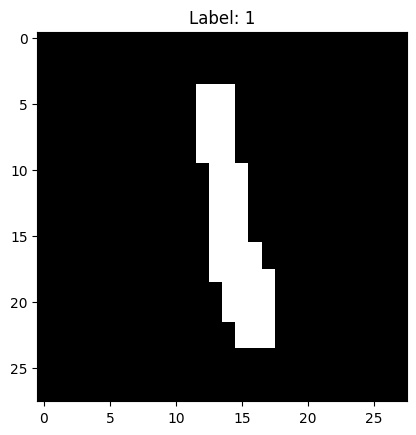

In [ ]:
# please consult torchvision here: https://pytorch.org/vision/stable/index.html
def to_binary(image):
    # Przekształcenie obrazu na wartości binarne: 0 (czarny) i 1 (biały)
    threshold = 0.5  # Ustal próg, gdzie wartości poniżej 0.5 będą czarne, a powyżej białe
    return (image > 0).float()

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Konwersja na czarno-biały obraz
    transforms.ToTensor(),  # Konwersja do tensora
    transforms.Normalize((0.5,), (0.5,)),  # Normalizacja
    transforms.Lambda(to_binary)
])

# first we get the training dataset from touchvision
training_data = torchvision.datasets.MNIST(root="../data", train=True, transform=transform, download=True)
test_data = torchvision.datasets.MNIST(root="../data", train=False, transform=transform, download=True)

# We then pass this dataset to our dataloader with specifications such as batch size
# consult the docs on dataloaders: https://pytorch.org/docs/stable/data.html#
training_data_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True, num_workers=2)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2)
image, label = training_data[6]

# Przekształcenie obrazu na format numpy
image = image.squeeze()  # Usuwamy wymiar kanału (ponieważ mamy tylko jeden kanał)

# Wyświetlanie obrazu w skali szarości
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")  # Wyświetlenie etykiety
plt.show()  # Wyświetlenie obrazu

In [ ]:
# Create a loss function

# note!! in pytorch the CrossEntropyLoss will apply softmax internally...
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
Epochs = 10
for epoch in range(Epochs):
  training_loss = 0.0
  correct = 0
  total = 0
  for i, data in enumerate(training_data_loader, 0):
    # get the inputs
    inputs, labels = data
    # Flatten the images

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    outputs = model(inputs)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    training_loss += loss.item()
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
    avg_loss = training_loss / (i + 1)
    avg_acc = 100. * correct / total
  print(f'Training Loss: {avg_loss:.3f} | Training acc: {avg_acc:.3f}', 'for epoch: ', epoch)

Training Loss: 0.765 | Training acc: 70.513 for epoch:  0
Training Loss: 0.523 | Training acc: 79.120 for epoch:  1
Training Loss: 0.459 | Training acc: 81.748 for epoch:  2
Training Loss: 0.440 | Training acc: 82.518 for epoch:  3


In [ ]:
torch.save(model.state_dict(), 'cnn_5.pth')
print("Model saved to 'cnn.pth'")